<a href="https://colab.research.google.com/github/Jagoda222/LoLa---group-8/blob/main/tunning%2Bordering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install accelerate -U
!pip install datasets==2.14.5


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.6.0 which is incompatible.


In [8]:
import torch
from os import path as op
import os
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from collections import Counter
from datasets import load_dataset, load_metric, concatenate_datasets, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# GPT2
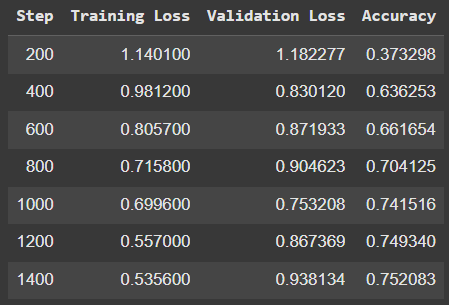

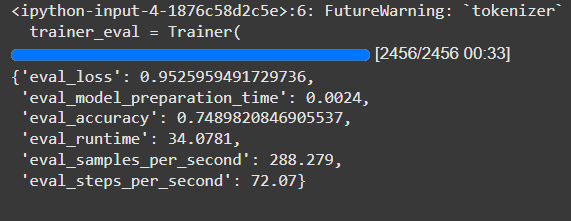

In [ ]:
# META Variables
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "gpt2"
BATCH_SIZE = 16

snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )


metric = load_metric('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Add a padding token for GPT-2 since it doesn’t have one by default
tokenizer.pad_token = tokenizer.eos_token

# https://huggingface.co/transformers/preprocessing.html
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)


model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    output_dir=MODEL_DIR,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_dir="./logs",
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Counter({0: 183416, 2: 183187, 1: 182764, -1: 785})


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

<ipython-input-3-0123d2d3e502>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', "mnli")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-0123d2d3e502>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
200,1.140100,1.182277,0.373298
400,0.981200,0.830120,0.636253
600,0.805700,0.871933,0.661654
800,0.715800,0.904623,0.704125
1000,0.699600,0.753208,0.741516
1200,0.557000,0.867369,0.749340
1400,0.535600,0.938134,0.752083


TrainOutput(global_step=1500, training_loss=0.7879597625732422, metrics={'train_runtime': 528.8622, 'train_samples_per_second': 11.345, 'train_steps_per_second': 2.836, 'total_flos': 99703983015936.0, 'train_loss': 0.7879597625732422, 'epoch': 3.0})

In [ ]:
# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["test"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()

<ipython-input-4-1876c58d2c5e>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_eval = Trainer(


{'eval_loss': 0.9525959491729736,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.7489820846905537,
 'eval_runtime': 34.0781,
 'eval_samples_per_second': 288.279,
 'eval_steps_per_second': 72.07}

# DeBERTA v3 small



In [11]:
# META Variables
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "microsoft/deberta-v3-small"
BATCH_SIZE = 16

snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )


metric = load_metric('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)


# https://huggingface.co/transformers/preprocessing.html
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)


model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    output_dir=MODEL_DIR,             # Directory to save model checkpoints
    evaluation_strategy="steps",      # Evaluates the model at regular intervals (defined by eval_steps)
    eval_steps=200,                   # Number of steps between evaluations
    save_steps=200,                   # Number of steps between saving checkpoints
    logging_steps=100,                # Number of steps between logging metrics
    per_device_train_batch_size=BATCH_SIZE, # Number of samples per training batch per device
    per_device_eval_batch_size=BATCH_SIZE,  # Number of samples per evaluation batch per device
    learning_rate=5e-5,               # Initial learning rate for the optimizer
    num_train_epochs=4,               # Total number of training epochs
    weight_decay=0.01,                # L2 weight regularization to prevent overfitting
    warmup_steps=200,                 # Number of warmup steps for the learning rate scheduler
    save_total_limit=2,               # Limits the number of saved checkpoints to save disk space
    load_best_model_at_end=True,      # Automatically loads the best checkpoint after training
    metric_for_best_model="accuracy", # Metric used to determine the best model during evaluation
    greater_is_better=True,           # Indicates whether a higher metric value is better
    logging_dir="./logs",             # Directory to save TensorBoard logs
    fp16=True,                        # Enables mixed precision training for faster computation
    lr_scheduler_type="cosine",       # Uses cosine learning rate decay for smoother transitions
)


triplets = [
    group for _, group in
    encoded_snli_data["train"].groupby("premise")
    if len(group) == 3
]

random.shuffle(triplets)
selected_triplets = []
total_sentences = 0
for triplet in triplets:
    if total_sentences + 3 > 2000:
        break
    selected_triplets.append(triplet)
    total_sentences += 3

train_dataset = Dataset.from_dict([ex for triplet in selected_triplets for ex in triplet])


trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Counter({0: 183416, 2: 183187, 1: 182764, -1: 785})


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in v

AttributeError: 'Dataset' object has no attribute 'groupby'

In [8]:
# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=train_dataset
    ,
    eval_dataset=encoded_snli_data["test"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()

<ipython-input-8-1876c58d2c5e>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_eval = Trainer(


{'eval_loss': 0.6184946298599243,
 'eval_model_preparation_time': 0.0025,
 'eval_accuracy': 0.8166734527687296,
 'eval_runtime': 11.0817,
 'eval_samples_per_second': 886.503,
 'eval_steps_per_second': 55.406}

## Sentence length


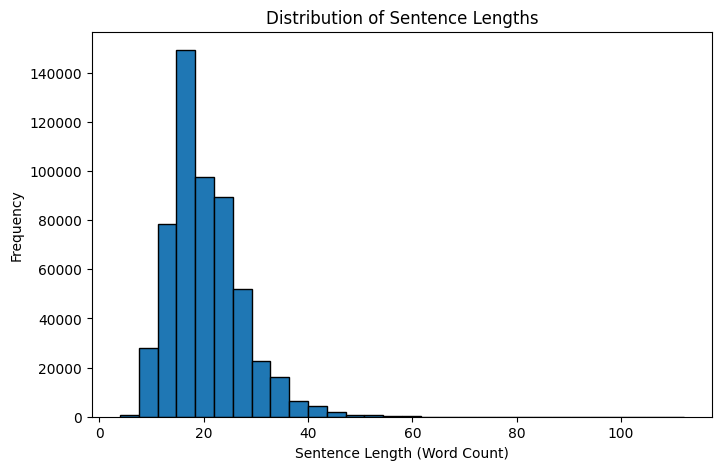

count    549367.000000
mean         20.265123
std           6.952120
min           4.000000
25%          15.000000
50%          19.000000
75%          24.000000
max         112.000000
Name: sentence_length, dtype: float64


In [27]:
train_df = pd.DataFrame(snli_data["train"])

# Plot a histogram of sentence lengths
plt.figure(figsize=(8, 5))
plt.hist(train_df['sentence_length'], bins=30, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length (Word Count)")
plt.ylabel("Frequency")
plt.show()

# Basic statistics about sentence lengths
print(train_df['sentence_length'].describe())

In [10]:
def add_sentence_length(example):
    combined_text = example['premise'] + " " + example['hypothesis']
    example['sentence_length'] = len(combined_text.split())  # Word count
    return example


In [11]:
snli_data["train"] = snli_data["train"].map(add_sentence_length)


Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

In [16]:
short_sentences = snli_data["train"].filter(lambda x: x['sentence_length'] < 15).shuffle(seed=42).select(range(667)).sort("sentence_length")
medium_sentences = snli_data["train"].filter(lambda x: 15 <= x['sentence_length'] < 25).shuffle(seed=42).select(range(666)).sort("sentence_length")
long_sentences = snli_data["train"].filter(lambda x: x['sentence_length'] >= 25).shuffle(seed=42).select(range(667)).sort("sentence_length")

# Combine sampled rows
diverse_sentences = concatenate_datasets([short_sentences, medium_sentences, long_sentences])

# Print the result
print(diverse_sentences)
print(f"Total rows: {len(diverse_sentences)}")

# Verify sentence length distribution
print("Sentence Length Distribution:")
print([row.get('sentence_length', None) for row in diverse_sentences])  # Use .get to safely access the key


Dataset({
    features: ['premise', 'hypothesis', 'label', 'sentence_length'],
    num_rows: 2000
})
Total rows: 2000
Sentence Length Distribution:
[6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

In [17]:
encoded_diverse_sentences = diverse_sentences.map(
    preprocess_function,
    batched=True,                # Tokenize multiple rows in parallel
    load_from_cache_file=False   # Ensures preprocessing runs fresh
)

# Verify tokenization output
print(encoded_diverse_sentences[0])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'premise': 'Energetic brown dog running', 'hypothesis': 'Pup running.', 'label': 0, 'sentence_length': 6, 'input_ids': [1, 74952, 3258, 1560, 997, 2, 48220, 997, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_diverse_sentences,
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-19-426f16effd4a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,0.421600,0.417250,0.848405
400,0.248100,0.561610,0.846779


TrainOutput(global_step=500, training_loss=0.3386335182189941, metrics={'train_runtime': 117.1964, 'train_samples_per_second': 68.261, 'train_steps_per_second': 4.266, 'total_flos': 93440046231648.0, 'train_loss': 0.3386335182189941, 'epoch': 4.0})

In [20]:
# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_diverse_sentences,
    eval_dataset=encoded_snli_data["test"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()

<ipython-input-20-f176052f2637>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_eval = Trainer(


{'eval_loss': 0.4166339039802551,
 'eval_model_preparation_time': 0.0018,
 'eval_accuracy': 0.8457858306188925,
 'eval_runtime': 10.9047,
 'eval_samples_per_second': 900.895,
 'eval_steps_per_second': 56.306}

## Questions

#### 1. In the provided project, they take the mean of hypothesis metric. In that way we measure the difference between the one premise and the avareg of (dis)similarity from the three hypothesis. To broad the idea we can repeat the ordering types, just handle triplets differently. Additionaly, we can add extra type of ordering.

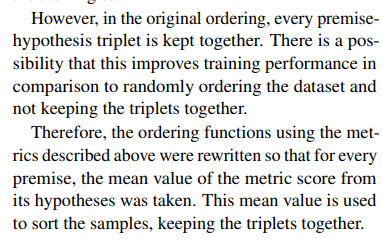

###2. Our baseline is the model perofrmance after tunning, run on random triplets?**pogrubiony tekst**

###3. Additional type orderings: Dependency Tree Similarity (gramamtical relationships between words), BLEU score? (used for translated text normally), Named Entity Overlap